In [1]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

PROJ = "My Drive/BBH_and_Machine_Learning"
PROJECT_PATH = join(ROOT, PROJ)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/My\ Drive/BBH_and_Machine_Learning/

/content/drive/My Drive/BBH_and_Machine_Learning


In [3]:
!make

to generate the dataset type make generate data=<dataname.hdf5>
to train the network type make train data=<dataname.hdf5> model=<modelname.pkl>
to test the network type make test data=<dataname.hdf5> model=<modelname.pkl>
to produce a corner plot type make corner data=<dataname.hdf5> model=<modelname.pkl>
default: data=datafile.hdf5 model=model.pkl


In [ ]:
## generate dataset
#!make generate data='qnm_3m_numerical.hdf5'

In [ ]:
## train network
#!make train data='qnm_3m_numerical.hdf5' model='model_cnn_z8.pkl'

In [4]:
## test network
!make test data='qnm_3m_numerical.hdf5' model='model_cnn_z8.pkl'

chmod u+x scripts/test.py
python3 scripts/test.py qnm_3m_numerical.hdf5 model_cnn_z8.pkl
trainable params: 57366
Training time: 60 mins
Sampling time: 31.571 secs
model score:  [0.06019192 0.02757576 0.03265657]


In [ ]:
## if corner is not installed:
#!pip install corner

In [7]:
## produce corner plot
!make corner data='qnm_3m_numerical.hdf5' model='model_cnn_z8.pkl'

chmod u+x scripts/corner_plot.py
python3 scripts/corner_plot.py qnm_3m_numerical.hdf5 model_cnn_z8.pkl
ground truth:  [65.07648316  0.80222756  1.51471471]


### Explore the produced plots

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

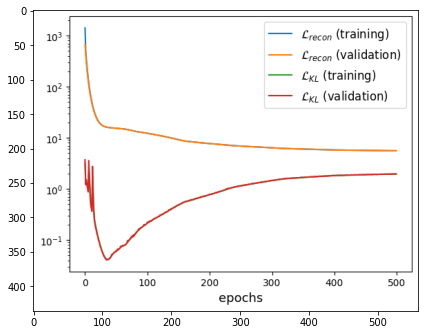

In [9]:
img = mpimg.imread(PROJECT_PATH + '/results/losses.png')
plt.figure(figsize=(6,6))
imgplot = plt.imshow(img)
plt.tight_layout()

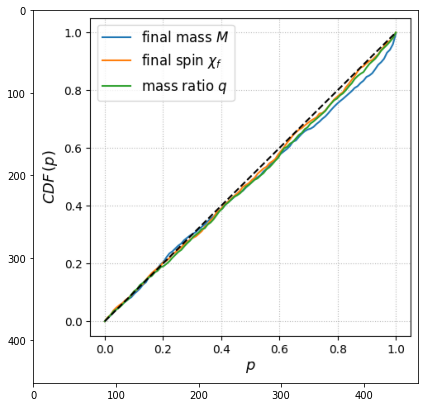

In [10]:
img = mpimg.imread(PROJECT_PATH + '/results/pp_plot.png')
plt.figure(figsize=(6,6))
imgplot = plt.imshow(img)
plt.tight_layout()

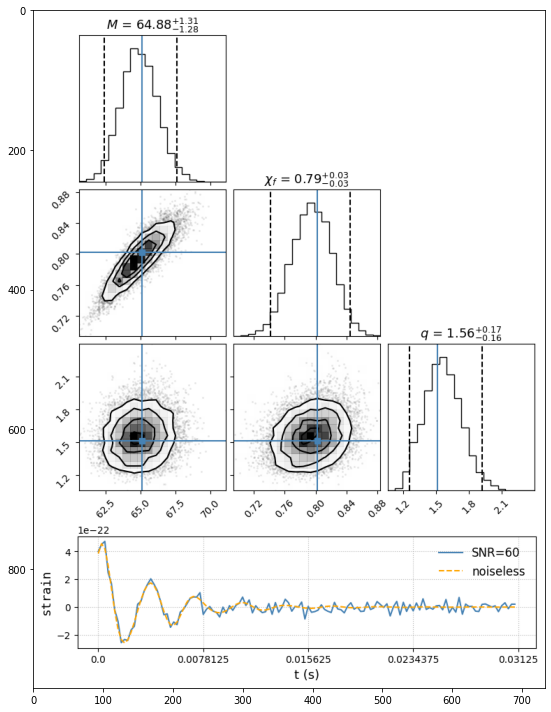

In [11]:
img = mpimg.imread(PROJECT_PATH + '/results/corner.png')
plt.figure(figsize=(10,10))
imgplot = plt.imshow(img)
plt.tight_layout()

# Test spin relation

In this section we want to show that the trained CVAE is able to recover the analytical relation between the spin and the mass ratio
$$
\chi_f = 2\sqrt{3}\eta-3.871\eta^2+4.028\eta^3+\mathcal{O}(\eta^4)
$$
where $\eta=q/(1+q)^2$ is the symmetric mass ratio. In our module, the above relation is expressed by the function `spin_fit`.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import torch

In [27]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
import sys
sys.path.append(PROJECT_PATH+'/src')
from cvae import GWDataset, Bayesian_Regressor, CVAE
from ringdown import spin_fit

In [20]:
## load the model
DEVICE = 'cuda'
modelfile = PROJECT_PATH+'/models/model_cnn_z8.pkl'
checkpoint = torch.load(modelfile)
net = CVAE(**checkpoint['params']).to(DEVICE)
model = Bayesian_Regressor(net)
model.load(modelfile)

In [24]:
## load the data
DATA_FILE = join(PROJECT_PATH,'data/qnm_3m_numerical.hdf5')
NOISE_FILE = PROJECT_PATH+'/data/noises.hdf5'

## prepare data
ny = 3
group='test2'
#NBINS = 128
with h5py.File(DATA_FILE,'r') as f:
  X_test = f[group+'/data'][()]
  y_test = f[group+'/target'][()][:,:ny]
  z_test = f[group+'/snr'][()]
  labels = f[group+'/target'].attrs['labels'][:ny]
testset = GWDataset(X_test,y_test,z_test)

with h5py.File(NOISE_FILE,'r') as f:
  noise = f['ET/noise'][()][-len(testset):]

### Stacking multiple events

In order to test the spin relation, we implement an ordinary least squared (OLS) fit. In particular, we consider the relation
$$
\chi_f^{\rm meas}=a+b\chi_f^{\rm infer}
$$
where
- $\chi_f^{\rm meas}$ is the measured value of the spin, defined as the median of the spin posteriors;
- $\chi_f^{\rm infer}$ is the spin as obtained from the spin relation using the measured value of the mass ratio $q^{\rm meas}$.

In the ideal case, $a=0$ and $b=1$. In practice, we will measure the success of the test by the amount to which $a$ and $b$ are compatible with $0$ and $1$, resspectively. We will perform the test using the module `statsmodels`.

In [39]:
## sample from the testset
SNR = np.random.uniform(40,80,len(testset))
X = testset.add_noise(noise,SNR)
n_samples = int(1e4)
samples = model.sample(X,n_samples);

In [28]:
def fit_results(samples,nobs):
  idx = np.random.choice(len(samples),nobs,replace=False)
  y = np.median(samples[idx,1],axis=-1)
  x = np.median(spin_fit(samples[idx,2]),axis=-1)
  X = np.vstack((x,np.ones(len(x))))
  mod = sm.OLS(y,X.T)
  res = mod.fit()
  df = pd.read_html(res.summary().tables[1].as_html(),header=0,index_col=0)[0]
  return df

def benchmark_fit(samples,nobs):
  mu = np.zeros((2,len(nobs)))
  scale = np.zeros((2,len(nobs)))
  nr = 10
  for i in range(len(nobs)):
    for j in range(nr):
      df = fit_results(samples,nobs[i])
      mu[:,i] += np.array(df['coef'])/nr
      scale[:,i] += np.array(df['std err'])/nr
  return mu, scale

In [40]:
fit_results(samples,len(samples))

,coef,std err,t,P>|t|,[0.025,0.975]
x1,0.9791,0.018,54.477,0.00,0.944,1.014
const,-0.0016,0.009,-0.177,0.86,-0.019,0.016


In [41]:
nobs = np.array([20,50,70,100,200,400,600,800,1000])
mu, scale = benchmark_fit(samples,nobs)
mm = mu-2*scale
mp = mu+2*scale

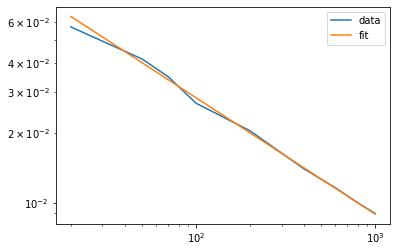

In [45]:
## intercept
plt.plot(nobs,scale[1],label='data')
plt.plot(nobs,0.2*np.sqrt(2/nobs),label='fit')
plt.legend()
plt.xscale('log')
plt.yscale('log')

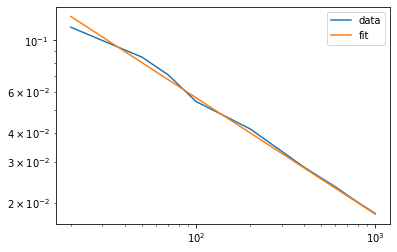

In [46]:
## intercept
plt.plot(nobs,scale[0],label='data')
plt.plot(nobs,0.4*np.sqrt(2/nobs),label='fit')
plt.legend()
plt.xscale('log')
plt.yscale('log')

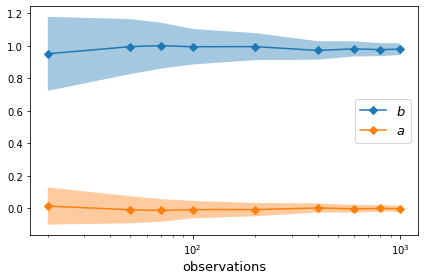

In [48]:
plt.plot(nobs,mu[0],'-D',label='$b$')
plt.plot(nobs,mu[1],'-D',label='$a$')
plt.fill_between(nobs,mm[0],mp[0],alpha=0.4)
plt.fill_between(nobs,mm[1],mp[1],alpha=0.4)
plt.xscale('log')
plt.xlabel('observations',fontsize=13)
plt.legend(fontsize=13,loc='center right')
plt.tight_layout()
#plt.savefig(PROJECT_PATH+'/results/ols_fit.png',bbox_inches='tight')

It is useful to display a scatter plot of $\chi_f^{\rm meas}$ versus $\chi_f^{\rm infer}$.

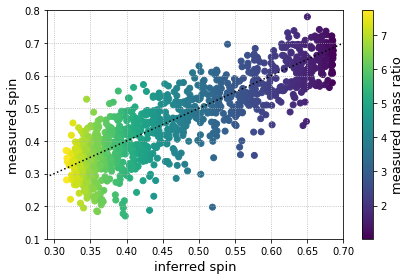

In [50]:
y = np.median(samples[:,1],axis=-1) # measured
x = np.median(spin_fit(samples[:,2]),axis=-1) # inferred
cm = plt.cm.get_cmap('RdYlBu')
q = np.median(samples[:,2],axis=-1)
eta = q
sc = plt.scatter(x,y,c=eta)
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('measured mass ratio', rotation=90, size=13)
plt.xlabel('inferred spin',fontsize=13)
plt.ylabel('measured spin',fontsize=13)
plt.xlim([0.29,0.7])
plt.ylim([0.1,0.8])
diag = np.linspace(0.1,0.8,100)
plt.plot(diag,diag,':',color='black')
plt.tight_layout()
plt.grid(linestyle=':',alpha=1)
#plt.savefig(PROJECT_PATH+'/results/scatter_spins.png',bbox_inches='tight')

### Single events

Here we show how to produce a scatter plot to assess the constistence of a single event with the GR null hypothesis.


In [51]:
!pip install corner
import corner

In [52]:
## sample from the testset
SNR = 60
X = testset.add_noise(noise,SNR)
n_samples = int(1e4)
samples = model.sample(X,n_samples);

In [53]:
spin_meas = samples[:,1]
spin_infer = spin_fit(samples[:,2])

ground truth:  [52.64628227  0.66164235  1.53290174]


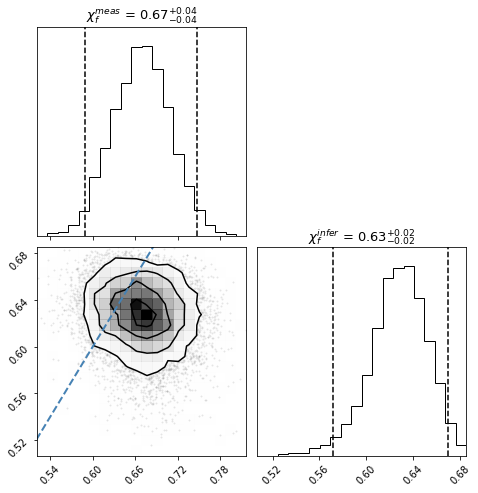

In [55]:
idx = np.argsort(testset.y[:,1],axis=0)
N = 920
p = 0.95
a = min((1-p)/2,(1+p)/2)
b = 1-a
X = np.vstack((spin_meas[idx[N]],spin_infer[idx[N]]))
print('ground truth: ',testset.y[idx[N]][:ny])
figure = corner.corner(X.T,titles=['$\chi^{meas}_f$','$\chi^{infer}_f$'],\
                       labels = None,\
                       quantiles=[a,b],\
                       show_titles=True,title_kwargs={'fontsize':13},\
                       #truths=[testset.y[idx[N]][1]]*2,truth_color='green',\
                       )
axes = np.array(figure.axes).reshape((2,2))
ax = axes[1,0]
#diag = np.linspace(min(spin_meas.min(),spin_infer.min()),\
#                   max(spin_meas.max(),spin_infer.max()),100)
diag = np.linspace(0,0.9,100)
ax.plot(diag,diag,'--',color='steelblue',linewidth=2)

figure.set_size_inches((8,8))
#figure.tight_layout()
#figure.savefig(PROJECT_PATH+'/results/identity_contour.png',bbox_inches='tight');